In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [ ]:
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [6]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [5]:

X_train = []
Y_train = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Training',i)
    for j in os.listdir(folderPath):
        img = os.path.join(folderPath,j)
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Testing',i)
    for j in os.listdir(folderPath):
        img = os.path.join(folderPath,j)
        X_train.append(img)
        Y_train.append(i)
        
## COnactenating the paths with the labesl 
FilePath = pd.Series(X_train, name = 'path')
LabelSeries = pd.Series(Y_train , name = 'Names')

df = pd.concat([FilePath,LabelSeries],axis = 1)

In [7]:
##Train test split
strat = df['Names']

train , test = train_test_split(df,test_size=0.1,random_state=123, stratify = strat)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
## Image Data Generator
batch_size = 8
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train, x_col= 'path', y_col= 'Names', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test, x_col= 'path', y_col= 'Names', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)


Found 2937 validated image filenames belonging to 4 classes.
Found 327 validated image filenames belonging to 4 classes.


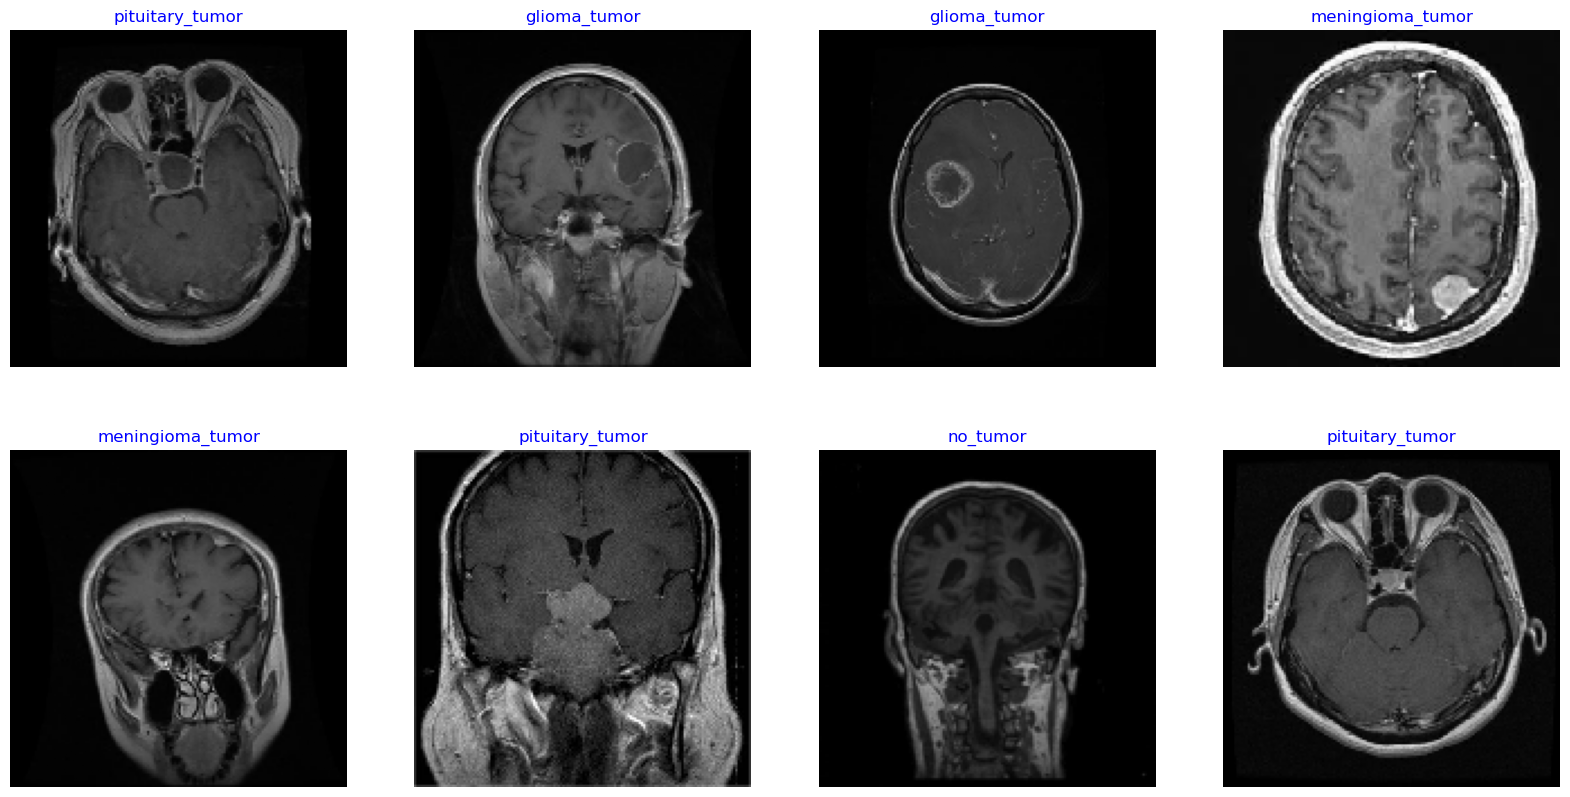

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, Names = next(train_gen)

plt.figure(figsize= (20, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(Names[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [14]:
# Create Model Structure  EfficientNet
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

Convolutional Neural Network

In [40]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add your custom classification layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10


2023-08-31 12:49:00.938058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


368/368 [==============================] - 106s 109ms/step - loss: 7.3519 - accuracy: 0.7000 - val_loss: 5.7895 - val_accuracy: 0.8349
Epoch 2/10
368/368 [==============================] - 36s 97ms/step - loss: 4.8434 - accuracy: 0.8315 - val_loss: 3.9208 - val_accuracy: 0.8991
Epoch 3/10
368/368 [==============================] - 36s 97ms/step - loss: 3.2531 - accuracy: 0.8870 - val_loss: 2.5935 - val_accuracy: 0.9205
Epoch 4/10
368/368 [==============================] - 35s 96ms/step - loss: 2.1885 - accuracy: 0.9285 - val_loss: 1.7646 - val_accuracy: 0.9388
Epoch 5/10
368/368 [==============================] - 36s 97ms/step - loss: 1.4868 - accuracy: 0.9411 - val_loss: 1.2450 - val_accuracy: 0.9297
Epoch 6/10
368/368 [==============================] - 35s 96ms/step - loss: 1.0555 - accuracy: 0.9472 - val_loss: 0.9197 - val_accuracy: 0.9388
Epoch 7/10
368/368 [==============================] - 36s 97ms/step - loss: 0.7539 - accuracy: 0.9656 - val_loss: 0.7154 - val_accuracy: 0.9450
E

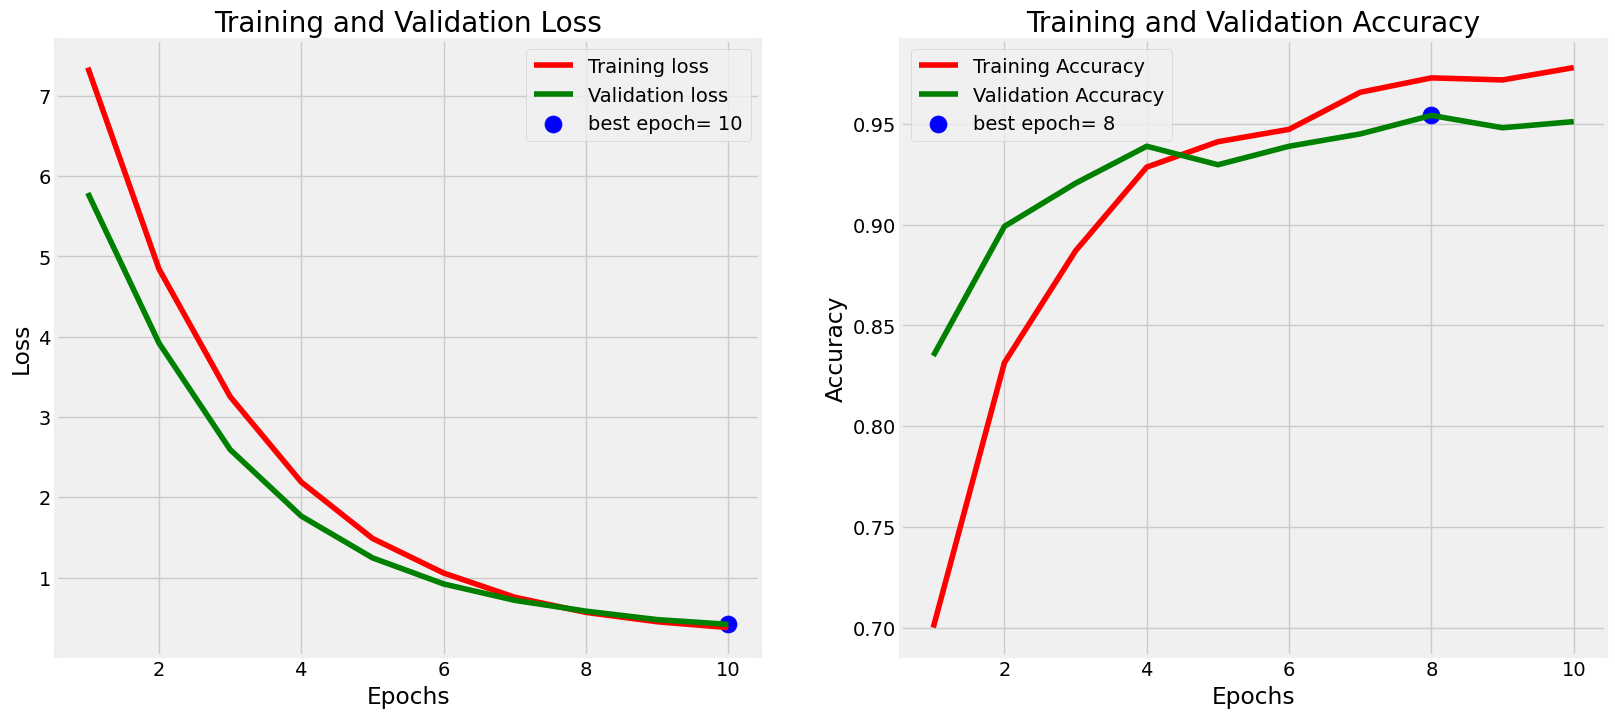

In [19]:
#model.save('braintumor.h5')

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'




# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [20]:
## Score for the EffiecientNet
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 1s 24ms/step - loss: 0.4170 - accuracy: 0.9511
Train Loss:  0.2747770845890045
Train Accuracy:  0.9979571104049683
--------------------
Test Loss:  0.4170425832271576
Test Accuracy:  0.9510703086853027


In [28]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)


41/41 [==============================] - 1s 25ms/step


(327, 4)

In [30]:
# Recognition report Of the EfficientNet
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.89      0.94        93
meningioma_tumor       0.93      0.96      0.94        94
        no_tumor       0.88      1.00      0.93        50
 pituitary_tumor       0.99      0.98      0.98        90

        accuracy                           0.95       327
       macro avg       0.95      0.96      0.95       327
    weighted avg       0.95      0.95      0.95       327

